In [1]:
import os
import tempfile
#numpy
import numpy as np
# pandas
from pandas import read_csv
# matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
#teras
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import AUC, Accuracy, Precision, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint


# sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
def plot_metrics(history):
    """
    This function plots performance of classifier considering different metrics.
    """
    metrics =  ['loss', 'AUC', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()

In [3]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          class_names = None,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    if class_names is None:
        x_labels = y_labels = classes
    else:
        x_labels = y_labels = class_names
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=x_labels, yticklabels=y_labels,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [4]:
METRICS = [
    AUC(name = 'AUC'),
    Accuracy(name = 'accuracy'),
    Precision(name = 'precision'),
    Recall(name = 'recall')    
]


def make_model(metrics = METRICS, output_bias = None):   
    """
    This function defines the classifier model
    """
    
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)    
    #Initialising NN
    model = Sequential()

    #First layer
    model.add(Dense(8, activation='relu', input_shape=(13,)))
    #model.add(BatchNormalization())
    model.add(Dropout(0.5))

    #Second layer
    model.add(Dense(12, activation='relu'))
   # model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(2, activation='sigmoid'))


    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(lr= 0.001),
                  metrics=metrics
                 )
    return model

In [5]:
def load_dataset(dataset_name, start_col, end_col):
    """
    This method loads the dataset if it exists
    """
    if not os.path.isfile(dataset_name):
        raise FileNotFoundError
        
    dataset = dataset_name
    first_col = start_col 
    last_col = end_col
    info = {
        "dataset_name" : dataset,
        "first_column"     : first_col,
        "last_column"      : last_col
    }
    
    return info

In [6]:
seed = 11   
np.random.seed(seed) 


dset = load_dataset("analysis.csv", start_col=2, end_col=15)    
dataframe = read_csv(dset["dataset_name"], header=0)
dataset = dataframe.values


X = dataset[:,int(dset["first_column"] ):int(dset["last_column"])].astype(float)   
Y = dataset[:,int(dset["last_column"])] #label column (15th) into Y 

#Encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)

#One-hot encoding
transformed_Y = to_categorical(encoded_Y)

In [7]:
bkg, sgn = np.bincount(encoded_Y)

total =  bkg + sgn
print('Samples:\n Total: {}\n Background: {} \n Signal: {} \n Signal samples are {:.2f}% of the total'.format(total, bkg, sgn, 100*sgn/total))

Samples:
 Total: 3800033
 Background: 3713773 
 Signal: 86260 
 Signal samples are 2.27% of the total


In [8]:
weight_for_0 = (1 / bkg)*(total)/2.0
weight_for_1 = (1 / sgn)*(total)/2.0


class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.51
Weight for class 1: 22.03


In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X,
                                                    transformed_Y,
                                                    test_size=0.25,
                                                    random_state=seed,
                                                    shuffle = True)

scaler = StandardScaler()
X_train =scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



In [10]:
print('Training labels shape:', Y_train.shape)
print('Validation labels shape:', Y_test.shape)


print('Training features shape:', X_train.shape)
print('Validation features shape:', X_test.shape)

Training labels shape: (2850024, 2)
Validation labels shape: (950009, 2)
Training features shape: (2850024, 13)
Validation features shape: (950009, 13)


In [11]:
EPOCHS = 10
BATCH_SIZE = 150000
val_data = (X_test,Y_test)
#checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_precision', verbose=1, save_best_only=True, mode='max')
#callbacks_list = [checkpoint]
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    verbose = 1,
    patience = 200,
    mode = 'min',
    restore_best_weights = True)



In [12]:
model = make_model()
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 112       
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 12)                108       
_________________________________________________________________
dropout_1 (Dropout)          (None, 12)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 26        
Total params: 246
Trainable params: 246
No

In [13]:
initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
model.save_weights(initial_weights)

In [14]:
model = make_model()
model.load_weights(initial_weights)

In [15]:
%%time
history=model.fit(X_train,
                  Y_train,
                  epochs = EPOCHS,
                  shuffle = True,
                  validation_data=val_data,
                  #validation_freq=5,
                  callbacks = [early_stopping],
                  batch_size = BATCH_SIZE,
                  class_weight=class_weight
                 )

Train on 2850024 samples, validate on 950009 samples
Epoch 1/10
2850024/2850024 [==============================] - 11s 4us/sample - loss: 0.9518 - AUC: 0.8694 - accuracy: 3.1754e-04 - precision: 0.7062 - recall: 0.7218 - val_loss: 0.5523 - val_AUC: 0.9587 - val_accuracy: 0.0000e+00 - val_precision: 0.9154 - val_recall: 0.9104
Epoch 2/10
2850024/2850024 [==============================] - 9s 3us/sample - loss: 0.8739 - AUC: 0.7813 - accuracy: 1.1158e-04 - precision: 0.6199 - recall: 0.6180 - val_loss: 0.5901 - val_AUC: 0.9139 - val_accuracy: 0.0000e+00 - val_precision: 0.8362 - val_recall: 0.7527
Epoch 3/10
2850024/2850024 [==============================] - 9s 3us/sample - loss: 0.8226 - AUC: 0.6959 - accuracy: 3.3859e-05 - precision: 0.5404 - recall: 0.5216 - val_loss: 0.6199 - val_AUC: 0.8414 - val_accuracy: 0.0000e+00 - val_precision: 0.7336 - val_recall: 0.5874
Epoch 4/10
2850024/2850024 [==============================] - 9s 3us/sample - loss: 0.7905 - AUC: 0.6231 - accuracy: 1.6842e

In [16]:
model.save_weights(initial_weights)

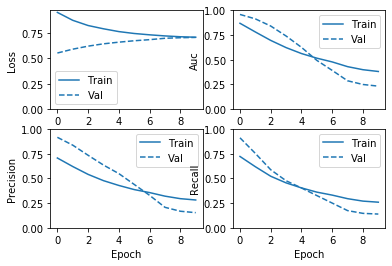

In [17]:
plot_metrics(history)

In [18]:
#compute predictions
predictions = model.predict(X_test)

y_pred = np.array([np.argmax(probas) for probas in predictions])
y_test = np.array([np.argmax(label) for label in Y_test])

classes = unique_labels(y_test, y_pred)
class_names = unique_labels(Y)

#not-fancy confusion matrix
cm = confusion_matrix(y_test, y_pred, labels = classes)

print(cm)

[[149717 778923]
 [  1356  20013]]


Confusion matrix, without normalization
[[149717 778923]
 [  1356  20013]]


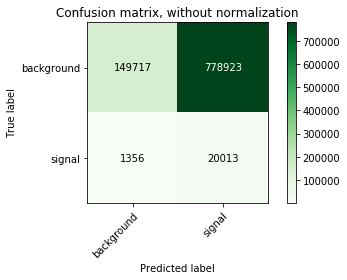

In [19]:
plot_confusion_matrix(y_test, y_pred, classes, class_names)